# Workshop 2
This workshop demonstrates how simple Collaborative Filtering (CF) can be easily coded without using CF libraries. The goal is to provide a hands-on insight into how CF algorithms work rather than to provide an 'industrial-strength' CF system.

#  Define some simple Collaborative Filtering functions

In [29]:
import pandas as pd
import numpy as np
from random import sample 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

# map the user_id's and item_id's in the raw ratings data (which may be strings) to contiguous integer indexes 
# (for use in indexing into arrays and matrices etc)
def mapdata(ratings_df):
  ratings_df["item_id"] = ratings_df["item_id"].astype(str)
  ratings_df["user_id"] = ratings_df["user_id"].astype(str)
  ratings_df["rating"]  = ratings_df["rating"].values.astype(np.float32)
  user_ids = np.sort(ratings_df["user_id"].unique()).tolist()
  umap = {x: i for i, x in enumerate(user_ids)}
  item_ids = np.sort(ratings_df["item_id"].unique()).tolist()
  imap = {x: i for i, x in enumerate(item_ids)}
  ratings_df["user_id"] = ratings_df["user_id"].map(umap) # swap userid for user index
  ratings_df["item_id"] = ratings_df["item_id"].map(imap) # swap itemid for item index
  return ratings_df, umap, imap

# apply CF to make predictions for all users and all items in a ratings matrix (users*items)
# for user-based CF: the input sims should be a user-user similarity matrix
# for item-based CF: the input sims should be a item-item similarity matrix
def predictRatings(ratmatrix, sims, itembased=False):

  # set the similarity matrix diagonal to zero, this ensures that an item's actual rating will not be used as an input to the rating prediction for that item
  # (note the above is only needed for user-based CF and only required if testing is done using using the training data)
  if (issparse(sims)):
    sims.setdiag(0)
  else:
    np.fill_diagonal(sims,0)

  # compute the dot product between ratings and similarities
  if itembased:
    # all ratings for each user * item similarities
    predrats = ratmatrix@sims 
    sumsims = (ratmatrix != 0)@(sims) 
  else:
    # all ratings for each item * user similarities
    predrats = sims@ratmatrix 
    sumsims = sims@(ratmatrix != 0) 

  # divide the dotproducts by the sum of similarities to get the weighted average ratings
  if (issparse(sims)):
    # there is no sparse divide, so use reciprocal and multiply
    np.reciprocal(sumsims.data, out=sumsims.data)
    return predrats.multiply(sumsims)
  else:
    return predrats/sumsims

# ignore warning messages for 0/0 divides
np.seterr(invalid='ignore')

# Sort (descending) a users predicted ratings for their unseen items, return the topN items
# input the users predicted ratings and the items to ignore (usually the items already seen/rated by the user)
def rankItems(predrats, ignoreitems=[], itemnames=dict(), topN=10):
  sorted_indexes = np.argsort(predrats)[::-1] # reverse sort
  sorted_indexes = np.roll(sorted_indexes,-np.count_nonzero(np.isnan(predrats))) # sort the nan's to the end
  res = list()
  for i in sorted_indexes:
    if not i in ignoreitems: 
        if i in itemnames: itemname = itemnames[i] 
        else: itemname = i
        res.append([predrats[i], itemname])
  return res[0:min(len(res),topN)]

  # Using the test ratings (actual and predicted), compute the prediction errors and the MAE.
def getMAE(testevents, predrats):
    errs = []
    for u, i, r in testevents.values:
        err = abs(r-predrats[int(u),int(i)])
        if not (np.isnan(err) or np.isinf(err)): 
          errs.append(err)
    return(np.mean(errs))

# estimate Mean Percentage Ranking and Lift from the testevents
# note: testevents should be pre-filtered to only include liked items (items that can be valid recommendations)
# note: ignoreitemids is a list of any items to be ignore during recommendations (e.g. most popular items)
def getMPR(testevents, predrats, trainrats, topN=10, ignoreitemids=[]):
    (_,nitems) = predrats.shape
    hits = rhits = sumpr = numpr = 0
    for user, item, rating in testevents.values:
        u = int(user)
        i = int(item)
        userpredrats = getRow(u,predrats)
        if np.isnan(userpredrats[i]): continue
        usertrainrats = getRow(u,trainrats)
        unseenitems  = np.where(np.logical_or(usertrainrats == 0, np.isnan(usertrainrats)))[0]
        seenitems    = np.where(usertrainrats != 0)[0]
        nanpreditems = np.where(np.isnan(userpredrats))[0]
        userpredrats[seenitems] = -10000  # seen items will sort to right
        userpredrats[nanpreditems] = -10000 # items with no prediction will sort to right
        ignoreitems = ignoreitemids.copy().remove(i) if i in ignoreitemids else ignoreitemids
        userpredrats[ignoreitems] = -10000 # ignore items also sort to the right
        sorted_indexes = np.argsort(userpredrats)[::-1] # reverse sort
        testitemrank = int(np.where(sorted_indexes == i)[0])
        numseenitems = len(seenitems)
        numprednans = len(nanpreditems)
        numvalidpreds = nitems-numprednans-numseenitems
        if testitemrank < min(topN, numvalidpreds): hits = hits + 1
        if i in sample(set(unseenitems),min(topN,len(unseenitems))): rhits = rhits + 1
        if testitemrank < numvalidpreds:
          sumpr = sumpr + ((testitemrank+1)*100)/(nitems-numseenitems)
          numpr = numpr + 1
    return hits, rhits, sumpr, numpr

# extract a row or column from a ratings matrix (sparse or dense) into a 1D array
def getRow(r, ratmatrix):
  if (issparse(ratmatrix)):
    return np.array(ratmatrix[r,:].todense())[0,:]
  else:
    return ratmatrix[r,:].copy()

def getCol(c, ratmatrix):
  if (issparse(ratmatrix)):
    return np.array(ratmatrix[:,c].todense())[:,0]
  else:
    return ratmatrix[:,c].copy()

# compute & print the percentage of cells in a rating matrix that are empty
def sparsity(arr):
    if issparse(arr):
      print("sparse matrix")
      print("dims=",arr.shape,"elements (if dense)=","{:,}".format(np.prod(arr.shape)))
      #numnan = len(arr.data[arr.data == np.nan])
      numnan = np.isnan(arr.data).sum()
      numzeros = len(arr.data[arr.data == 0])
      pcmissing = 100 - (len(arr.data)*100.0)/np.prod(arr.shape)
      #pcnotvalid = 100 - (numvalid*100.0)/np.prod(arr.shape)
      print("%","empty= %1.5f (#dataitems=%d #datazeros=%d #datanans=%d)" % (pcmissing,len(arr.data),numzeros,numnan))
      print("bytes used=", "{:,}".format(arr.data.nbytes + arr.indptr.nbytes + arr.indices.nbytes))
    else:
      print("dense matrix")
      print("dims=",arr.shape,"elements=","{:,}".format(np.prod(arr.shape)))
      numnan = np.isnan(arr).sum()
      numzero = np.sum(arr == 0)
      #print("#nan values=",numempty,"#zeros=",np.sum(arr == 0))
      pcempty = ((numnan)*100.0)/arr.size
      print("%","empty(nan)= %1.5f (#nans=%d, #zeros=%d)" % (pcempty,numnan,numzero)) 
      print("bytes used=", "{:,}".format(arr.nbytes))

# compute % similarity between two dense arrays 
def pcsame(a1,a2):
  c = a1 == a2
  return (float)(c.sum()*100)/np.prod(a1.shape)

# show stats/histogram for the ratings in an array/matrix
import matplotlib.pyplot as plt
def plotrats(rats):
  if issparse(rats):
    drats = rats.data
  else:
    drats = rats
  validrats = (np.isnan(drats)==False) & (drats > 0)
  print('min=',np.min(drats[validrats]), 'max=', np.max(drats[validrats]), 'mean=', np.mean(drats[validrats]))
  x = drats[validrats].flatten() 
  plt.hist(x, bins = 20)
  plt.show()

We now apply the above defined functions to the 4 datasets below. Each dataset introduces some new concepts:

# Simple Movies Dataset



In [30]:
# load the Toby dataset (simple demo dataset)
file = r"D:\bigdata\RSC\day1\workshop2\simplemovies-transactions.csv"
ratingevents = pd.read_csv(file)
ratingevents.columns = ['user_id','item_id','rating']
ratingevents = ratingevents[ratingevents['user_id'] != "Barry"]
print(ratingevents[0:5])

  user_id        item_id  rating
0    Rose    LadyinWater     2.5
1    Rose  SnakesOnPlane     3.5
2    Rose     JustMyLuck     3.0
3    Rose       Superman     3.5
4    Rose         Dupree     2.5


In [31]:
# map the user and item ids to integers, overwrite the original data
ratingevents, umap, imap = mapdata(ratingevents)
nusers = len(umap)
nitems = len(imap)
print(ratingevents[0:4])
print('nusers=',nusers,'nitems=',nitems)

   user_id  item_id  rating
0        4        2     2.5
1        4        4     3.5
2        4        1     3.0
3        4        5     3.5
nusers= 7 nitems= 6


In [32]:
#FYI: we can create a dense ratings matrix from the rating events (users ~ rows and items ~ columns) but this is not very scalable
uimatrix = pd.pivot_table(ratingevents, index=['user_id'], columns=['item_id'], values=['rating'],aggfunc=[np.mean]).values
print(uimatrix)

[[2.  2.  3.  3.  4.  3. ]
 [3.5 nan 3.  3.  4.  5. ]
 [nan nan 2.5 4.  3.  3.5]
 [2.5 3.  nan 4.5 3.5 4. ]
 [2.5 3.  2.5 3.  3.5 3.5]
 [3.5 1.5 3.  3.  3.5 5. ]
 [1.  nan nan nan 4.5 4. ]]


In [33]:
#get some basic stats about its sparseness (how many missing ratings)
sparsity(uimatrix)

dense matrix
dims= (7, 6) elements= 42
% empty(nan)= 16.66667 (#nans=7, #zeros=0)
bytes used= 168


In [34]:
# create a sparse ratings matrix from the rating events
uimatrix = csr_matrix((ratingevents.rating,(ratingevents.user_id,ratingevents.item_id)),shape=(nusers,nitems))
print(uimatrix.todense())

[[2.  2.  3.  3.  4.  3. ]
 [3.5 0.  3.  3.  4.  5. ]
 [0.  0.  2.5 4.  3.  3.5]
 [2.5 3.  0.  4.5 3.5 4. ]
 [2.5 3.  2.5 3.  3.5 3.5]
 [3.5 1.5 3.  3.  3.5 5. ]
 [1.  0.  0.  0.  4.5 4. ]]


In [35]:
# Examine the memory required for the sparse matrix.
# (Note: for this trivial dataset a sparse matrix requires more memory than a dense matrix,
#  but usually a sparse matrix representation will be much better for typical ratings data)
sparsity(uimatrix)

sparse matrix
dims= (7, 6) elements (if dense)= 42
% empty= 16.66667 (#dataitems=35 #datazeros=0 #datanans=0)
bytes used= 312


In [36]:
# For this demo, we compute up-front the user-user similarity matrix.
# In a session-based recommender system we would probably compute the user-user similarities in real-time
# during the session in order to use up-to-date data for the target user, e.g. their page-views in the current/active session.
usersims = cosine_similarity(uimatrix, dense_output=True) # outputs a dense matrix by default (note: if using dense input then ensure all na's are first replaced with 0's)
#usersims = 1/(1+euclidean_distances(uimatrix)) # use an alternative similarity metric
print(usersims)
sparsity(usersims)

[[1.0000001  0.9289888  0.8917017  0.8856583  0.9818314  0.95569134
  0.73417866]
 [0.9289888  1.         0.8801547  0.8346223  0.9065507  0.9823251
  0.8055501 ]
 [0.8917017  0.8801547  1.         0.80705696 0.83821976 0.86233675
  0.68316394]
 [0.8856583  0.8346223  0.80705696 0.99999994 0.92884076 0.8847892
  0.7028414 ]
 [0.9818314  0.9065507  0.83821976 0.92884076 0.99999994 0.9606463
  0.71250063]
 [0.95569134 0.9823251  0.86233675 0.8847892  0.9606463  1.
  0.7700243 ]
 [0.73417866 0.8055501  0.68316394 0.7028414  0.71250063 0.7700243
  1.        ]]
dense matrix
dims= (7, 7) elements= 49
% empty(nan)= 0.00000 (#nans=0, #zeros=0)
bytes used= 196


In [37]:
# make user-based CF rating predictions for all users and all items in uimatrix
predrats = predictRatings(uimatrix, usersims)
print(predrats)

[[2.674621  2.4922264 2.7507415 3.47809   3.6399808 4.176256 ]
 [2.3451123 2.3422356 2.7584238 3.4703856 3.6554775 3.8426404]
 [2.5547884 2.357163  2.879303  3.282882  3.8161812 4.086986 ]
 [2.5524743 2.1802127 2.8000567 3.1859167 3.7298768 3.9932208]
 [2.5684865 2.1562061 2.8863351 3.483414  3.7322533 4.0875006]
 [2.3571296 2.6588187 2.7576466 3.4712915 3.7414901 3.836616 ]
 [2.8244174 2.352908  2.8116724 3.3941298 3.5971546 4.032567 ]]


In [38]:
# generate the user-based CF recommendations for Toby, these should agree with the lecture notes (nightlistener=3.39, ladyinwater=2.81, justmyluck=2.35)
itemnamemap = dict(zip(imap.values(), imap.keys())) # first create a dict to convert the item indexes back to item names
targetindex = umap["Toby"]
seenitems = np.where(getRow(targetindex, uimatrix) != 0)[0]
rankItems(getRow(targetindex,predrats), ignoreitems=seenitems,  itemnames=itemnamemap) #reverse sort the target's unseen items by their predicted rating

[[3.3941298, 'NightListener'],
 [2.8116724, 'LadyinWater'],
 [2.352908, 'JustMyLuck']]

In [39]:
# compute the item-item similarity matrix and then use this to generate item-based CF recommendations for Toby
# these should also agree with the lecture notes (nightlistener=3.20, ladyinwater=3.17, justmyluck=3.10)  
itemsims = cosine_similarity(uimatrix.transpose()) # we transpose in order to calc similarities between items and not users
#itemsims = 1/(1+euclidean_distances(uimatrix.transpose()))
predrats = predictRatings(uimatrix, itemsims, itembased=True)
rankItems(predrats[targetindex,:], ignoreitems=seenitems,  itemnames=itemnamemap)

[[3.2040763, 'NightListener'],
 [3.1731205, 'LadyinWater'],
 [3.100052, 'JustMyLuck']]

In [40]:
# we can also try mean-centring (normalising) the data first
usermeans = ratingevents[['user_id','rating']].groupby(by=['user_id']).mean().values.flatten()
ratingevents['normrating'] = ratingevents['rating'] - usermeans[ratingevents['user_id']]
normuimatrix = csr_matrix((ratingevents.normrating,(ratingevents.user_id,ratingevents.item_id)),shape=(nusers,nitems))
print(normuimatrix.todense()) # show the normalised ratings matrix

[[-0.83333325 -0.83333325  0.16666675  0.16666675  1.1666667   0.16666675]
 [-0.20000005  0.         -0.70000005 -0.70000005  0.29999995  1.3       ]
 [ 0.          0.         -0.75        0.75       -0.25        0.25      ]
 [-1.         -0.5         0.          1.          0.          0.5       ]
 [-0.5         0.         -0.5         0.          0.5         0.5       ]
 [ 0.25       -1.75       -0.25       -0.25        0.25        1.75      ]
 [-2.1666667   0.          0.          0.          1.3333333   0.83333325]]


In [41]:
# re-do the user-based CF recommendations using the mean-centred data
# Are the recommendations the same as before?
normusersims = cosine_similarity(normuimatrix) 
normpredrats = predictRatings(normuimatrix, normusersims) 
rankItems(normpredrats[targetindex,:], ignoreitems=seenitems, itemnames=itemnamemap)

# Note: the rating predictions shown below are predictions for the normalised ratings
# to show the unnormalised rating predictions we should add back the target user's mean rating 
# but this is not necessary to determine which items to recommend (since only a sort is required)

[[0.18523517, 'NightListener'],
 [-0.27334818, 'LadyinWater'],
 [-0.8117572, 'JustMyLuck']]

# Movielens Dataset

In [42]:
#(M1) load the movielens 100K dataset
file = r"D:\bigdata\RSC\day1\workshop2\u_data.csv"
ratingevents = pd.read_csv(file)
ratingevents.columns = ['user_id','item_id','rating','datetime']
ratingevents.drop('datetime',axis=1,inplace=True)
print('raw data dims=',ratingevents.shape)
print('before mapping\n',ratingevents[0:4])
ratingevents, umap, imap = mapdata(ratingevents)
print('after mapping\n',ratingevents[0:4])
nusers = len(umap)
nitems = len(imap)
print('nuser=',nusers,'nitems=',nitems)

raw data dims= (100000, 3)
before mapping
    user_id  item_id  rating
0        1        1       5
1        1        2       3
2        1        3       4
3        1        4       3
after mapping
    user_id  item_id  rating
0        0        0     5.0
1        0      794     3.0
2        0      905     4.0
3        0     1016     3.0
nuser= 943 nitems= 1682


In [43]:
# (M2) split the rating events into training events and test events then create a ratings matrix from the training events
numtestrats = 10000  # 10% of the data
testidx  = sample(range(ratingevents.shape[0]), numtestrats)
trainidx = list(set(range(ratingevents.shape[0])) - set(testidx))
trainevents = ratingevents.iloc[trainidx,]
testevents  = ratingevents.iloc[testidx,]
del [ratingevents] # no longer needed, can delete to save memory
# create the sparse ratings matrix
uimatrix = csr_matrix((trainevents.rating,(trainevents.user_id,trainevents.item_id)),shape=(nusers,nitems))

In [44]:
# FYI: determine what % of the ratings matrix is empty (contains no rating)
sparsity(uimatrix)

sparse matrix
dims= (943, 1682) elements (if dense)= 1,586,126
% empty= 94.32580 (#dataitems=90000 #datazeros=0 #datanans=0)
bytes used= 723,776


In [45]:
# (M3) to make user-based rating predictions for all users and items we first compute the user similarity matrix
usersims = cosine_similarity(uimatrix)  # output is a dense matrix by default
#usersims = 1/(1+euclidean_distances(uimatrix))
sparsity(usersims)

dense matrix
dims= (943, 943) elements= 889,249
% empty(nan)= 0.00000 (#nans=0, #zeros=40428)
bytes used= 3,556,996


In [46]:
# FYI: in this case, is it better to store the similarity matrix in sparse format?
# let's try, what conclusion can you make? .... 
usersims = cosine_similarity(uimatrix, dense_output = False)
sparsity(usersims)

sparse matrix
dims= (943, 943) elements (if dense)= 889,249
% empty= 4.54631 (#dataitems=848821 #datazeros=0 #datanans=0)
bytes used= 6,794,344


In [47]:
# (M4) predict all ratings and compute the MAE for the test events
predrats = predictRatings(uimatrix, usersims) # the default method is user-based CF
print("MAE=",getMAE(testevents, predrats))

MAE= 0.8040024454653263


In [48]:
# FYI: we can also compute the MAE for the training data
# this is usually lower that the MAE for the test data 
print("MAE=",getMAE(trainevents, predrats))

MAE= 0.8102267514559958


min= 1.0 max= 5.0 mean= 3.5297778


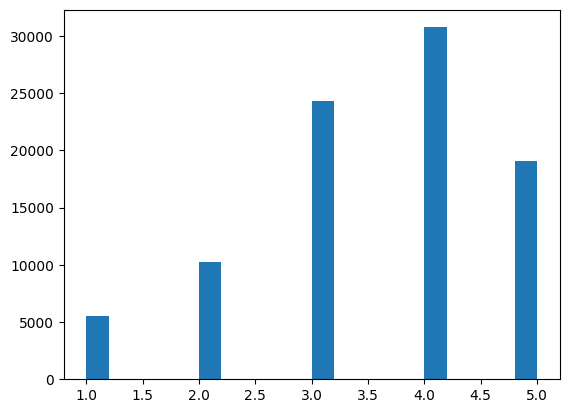

min= 0.99999994 max= 5.000001 mean= 3.0562375


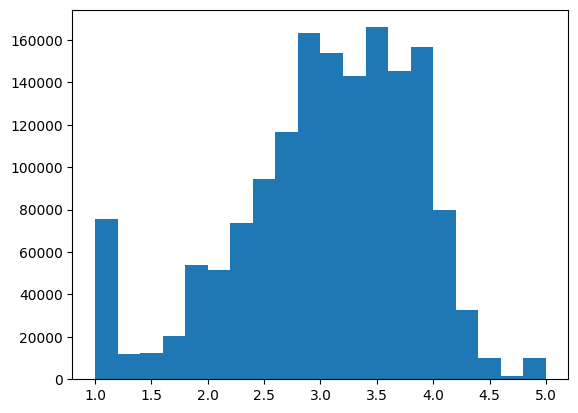

In [49]:
# FYI: show histograms for the actual and the predicted ratings
# What do you notice about the distributions?
plotrats(uimatrix)
plotrats(predrats)

In [50]:
# (M5) Now test the item-based CF rating predictions
itemsims = cosine_similarity(uimatrix.transpose())
#itemsims = 1/(1+euclidean_distances(uimatrix.transpose()))
predrats = predictRatings(uimatrix, itemsims, itembased=True)
print("MAE=",getMAE(testevents, predrats))

MAE= 0.7993000764392307


Now try mean-centring the data to see if this improves performance.

In [51]:
# (M6) Normalise the train and test events using the user-means computed from the train events.
# Note1: For correct testing, we must compute the user means only from the training data.
# Note2: We add 100 to the normalised ratings to ensure they are all positive integers
# Note3: This step overwrites all existing data, to revert back to testing un-normalised data you must reload the data from file
usermeans = trainevents[['user_id','rating']].groupby(by=['user_id']).mean()
usermeandict = dict(zip(usermeans.index.tolist(), usermeans.values.flatten()))
trainevents['rating'] = 20 + trainevents['rating'] - trainevents['user_id'].map(usermeandict)
testevents['rating']  = 20 + testevents['rating'] - testevents['user_id'].map(usermeandict)
uimatrix = csr_matrix((trainevents.rating,(trainevents.user_id,trainevents.item_id)),shape=(nusers,nitems))
sparsity(uimatrix)

sparse matrix
dims= (943, 1682) elements (if dense)= 1,586,126
% empty= 94.32580 (#dataitems=90000 #datazeros=0 #datanans=0)
bytes used= 723,776


In [52]:
# now cut and paste code from above to re-test user-based and item-based CF on this mean-centred data
# OR alternatively, scroll up and re-execute the appropriate code blocks: M3 and M4 (to test UB) then M5 (to test IB) 
#.....



Investigate alternate ways of testing the recommendations using Mean Percentage Ranking (MPR) and Lift. \

This takes as input a set of ratings predictions (predrats). These must first be generated using either user-based CF or item-based CF, and using any similarity metric that you choose. \

**Note** that the below code only works for *un-normalised* data, hence you must first reload the movielens data from file (re-run M1), split into training and test sets (re-run M2) and then generate the predictions again (run M3, M4 for user-based, or run M5 for item-based) without doing mean-centering of the data. 

In [53]:
# (M7) compute MPR and lift for a range of values of topN
# This only works with UN-NORMALISED DATA, hence first reload the raw data using code cells: M1, M2
# This inputs the predicted ratings: hence also execute code cells: M3 and M4 (to test user-based). To test item-based execute M5.
testlikes = testevents[testevents['rating'] >= 5] # select only the certain likes (this does not work on mean-centred data)
print('num likes=',len(testlikes))
for i in [10,15,20,30,50,100,200,300,400,500,1000]:
  hits, rhits, mpr, n = getMPR(testlikes, predrats, uimatrix, topN=i)
  lift = float(hits)/rhits if rhits > 0 else 0 
  mpr = mpr/n if n > 0 else 0
  print('topN=%3d, mpr=%0.2f n=%d lift=%0.2f (%d/%d)' % (i,mpr,n,lift,hits,rhits, ))

num likes= 10000


TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

Lastly, we can use the predicted ratings to make recommendations for a specific user

In [55]:
# First load the movie names from file and create a reverse lookup dict between movie names (titles) and item indexes
file = r"D:\bigdata\RSC\day1\workshop2\u_item.csv"
titles = pd.read_csv(file, dtype=str)
#print(titles[0:2]) # show a sample of the file, it also contains movie genre info - but we ignore this
titles["movie index"] =  titles["movie id"].map(imap)
titles = titles[~np.isnan(titles['movie index'])]
movienames = dict(zip(titles["movie index"].astype(int),titles["movie name"]))
# print a small sample of the dict
for i in range(5):
    print(i, movienames[i])

0 Toy Story (1995)
1 Richard III (1995)
2 Fargo (1996)
3 Lightning Jack (1994)
4 Stupids, The (1996)


In [56]:
# Select a user as target and generate the recommendations
target = umap['10'] 
seenitemindexes = np.where(getRow(target, uimatrix) != 0)[0]   
rankItems(getRow(target,predrats), ignoreitems=seenitemindexes, itemnames=movienames)

[[4.4468293, 'Mirage (1995)'],
 [4.4077854, 'Good Man in Africa, A (1994)'],
 [4.394256, 'The Deadly Cure (1996)'],
 [4.370133, 'Witness (1985)'],
 [4.350709, 'Spirits of the Dead (Tre passi nel delirio) (1968)'],
 [4.347152, 'Marlene Dietrich: Shadow and Light (1996) '],
 [4.3465514, 'Wife, The (1995)'],
 [4.3419876, 'Innocents, The (1961)'],
 [4.34138, 'Crossfire (1947)'],
 [4.341272, 'Golden Earrings (1947)']]

In [57]:
# For comparison, we show the top items that the user has already given ratings too (ie likes the most)
# Do the above recommendations seem reasonable by comparison?
unseenitemindexes = np.where(getRow(target, uimatrix) == 0)[0]
rankItems(getRow(target,uimatrix), ignoreitems=unseenitemindexes, itemnames=movienames)

[[20.795181, 'Wild Bunch, The (1969)'],
 [20.795181, 'African Queen, The (1951)'],
 [20.795181, 'Bonnie and Clyde (1967)'],
 [20.795181, 'Magnificent Seven, The (1954)'],
 [20.795181, 'Treasure of the Sierra Madre, The (1948)'],
 [20.795181, 'Big Sleep, The (1946)'],
 [20.795181, 'Shine (1996)'],
 [20.795181, 'Pulp Fiction (1994)'],
 [20.795181, 'American in Paris, An (1951)'],
 [20.795181, 'Rear Window (1954)']]

# Jester Dataset

In [58]:
#(J1) load the ratings data
file = r"D:\bigdata\RSC\day1\workshop2\jester_ratings.dat"

ratingevents = pd.read_csv(file, sep='\s+',header=None)
ratingevents.columns = ['user_id','item_id','rating']
print('raw data dims=',ratingevents.shape)
ratingevents['rating'] = ratingevents['rating']  + 10 # convert to positive integers
print('before mapping\n',ratingevents[0:3])
ratingevents, umap, imap = mapdata(ratingevents)
print('after mapping\n',ratingevents[0:3])
nusers = len(umap)
nitems = len(imap)
print('nuser=',nusers,'nitems=',nitems)

raw data dims= (1761439, 3)
before mapping
    user_id  item_id  rating
0        1        5  10.219
1        1        7   0.719
2        1        8   0.719
after mapping
    user_id  item_id  rating
0        0       87  10.219
1        0      108   0.719
2        0      119   0.719
nuser= 59132 nitems= 140


In [ ]:
#FYI: examine the distribution of the ratings
plotrats(ratingevents['rating'].values)

In [ ]:
# (J2) split the rating events into training events and test events and create a sparse ratings matrix from the training events
numtestrats = 10000
testidx  = sample(range(ratingevents.shape[0]), numtestrats)
trainidx = list(set(range(ratingevents.shape[0])) - set(testidx))
trainevents = ratingevents.iloc[trainidx,]
testevents  = ratingevents.iloc[testidx,]
del [ratingevents] # no longer needed, delete to save memory
uimatrix = csr_matrix((trainevents.rating,(trainevents.user_id,trainevents.item_id)),shape=(nusers,nitems))

In [ ]:
# (J3) Now try to test user-based CF (this will probably fail due to insufficient memory if using the whole dataset)
usersims = cosine_similarity(uimatrix, dense_output = False)
predrats = predictRatings(uimatrix, usersims)
print("MAE=",getMAE(testevents, predrats))

Testing user-based CF fails due to lack of memory, why?\
Note: if your colab session has crashed then you must re-execute the code in the section **'simple collaborative filtering functions'** \
and then reload the Jester data (using code cell J1) before continuing.

In [ ]:
# (J4) Lets try user-based CF again by first reducing the number of users by keeping only active users
# run this cell only after reloading the data from file by running code cell J1 (but do not run J2)

min_user_ratings = 80 # set minimum user activity threshold (you can adjust this if you wish)
active_users = ratingevents['user_id'].value_counts() >= min_user_ratings
active_users = active_users[active_users].index.tolist()
print('#users before filtering:',len(ratingevents['user_id'].unique()))
ratingevents = ratingevents[ratingevents['user_id'].isin(active_users)] 
print('#users after filtering:', len(ratingevents['user_id'].unique()))
print('#rating events:',len(ratingevents))

In [ ]:
# Now recreate the training and test sets and retest user-based CF 
# do this by rexecuting the code cells: J2 (split) then J3 (test UB)
# What is the MAE? Is it good or bad?
#....

**Now try Item-based CF** \
\
This will succeed without the need to subset/reduce the dataset, hence you can if you wish reload all of the data from file (run J1, J2), \
or just continue without reloading the data (ie keep using the reduced data set comprising only very active users)

What MAE is acceptable given that the ratings range (0->20) is much larger than the movielens ratings range (1->5)?

In [ ]:
# (J5) test item-based CF rating predictions
itemsims = cosine_similarity(uimatrix.transpose(), dense_output = False)
#itemsims = 1/(1+euclidean_distances(uimatrix.transpose()))
predrats = predictRatings(uimatrix, itemsims, itembased=True)
print("MAE=",getMAE(testevents, predrats))

In [ ]:
# FYI: what % of ratings were predicted?
sparsity(predrats)

In [ ]:
plotrats(uimatrix)
plotrats(predrats)

**Does mean-centering the data improve the MAE?** 

In [ ]:
# To investigate mean-centering, re-execute (or paste here) the appropriate code.
# The order of code cells to execute is: 
# J1 (load), J4 (reduce), J2 (split), M6 (mean-centre), J3 (test UB) , J5 (test IB)
# .....

**Now examine some actual recommendations for a few test users**

In [ ]:
# we first load the joke texts from file and create a lookup dict between item index and joke text
file = "/content/drive/My Drive/recsys/jester_jokes.csv"
jokes = pd.read_csv(file)
jokes["jnum"] = jokes["jnum"].astype(str)
# overwrite jnum with the item index
jokes["jnum"] = jokes["jnum"].apply(lambda x: imap[x] if x in imap else int(-1))
jokelookup = dict(zip(jokes["jnum"],jokes["joke"])) # maps item index -> joke text
# show a sample of jokes
for i in range(5): print(i, jokelookup[i])

In [ ]:
# Now select a user as target and generate some recommendations for that user
target = umap['10'] 
seenitemindexes = np.where(getRow(target, uimatrix) != 0)[0]    
rankItems(getRow(target,predrats), ignoreitems=seenitemindexes, itemnames=jokelookup, topN=3)

In [ ]:
# We can examine the top jokes that we know the user likes - but its hard to draw any conclusions from this :-)
unseenitemindexes = np.where(getRow(target, uimatrix) == 0)[0]
rankItems(getRow(target,uimatrix), ignoreitems=unseenitemindexes, itemnames=jokelookup, topN=3)

# Book Crossing dataset
This is a huge, very sparse dataset

In [ ]:
from numpy.ma.core import maximum_fill_value
# load and map the BX data
file = "/content/drive/My Drive/recsys/BX-Book-Ratings.csv"
ratingevents  = pd.read_csv(file, sep=';', encoding="latin-1")
ratingevents.columns = ['user_id','item_id','rating']
ratingevents = ratingevents[ratingevents.rating != 0]  # remove the implicit ratings
#ratingevents["item_id"] = ratingevents["item_id"].apply(lambda x: x.strip())
ratingevents, umap, imap = mapdata(ratingevents)
nusers = len(umap)
nitems = len(imap)
print('nusers=',nusers,'nitems=',nitems,'numratings=',len(ratingevents),'min,max rating=',min(ratingevents['rating']),max(ratingevents['rating']))
print(ratingevents[:5])

In [ ]:
#FYI: examine the distribution of the ratings
plotrats(ratingevents['rating'].values)

In [ ]:
# split the rating events into training and test events
numtestrats = 10000
testidx  = sample(range(ratingevents.shape[0]), numtestrats)
trainidx = list(set(range(ratingevents.shape[0])) - set(testidx))
testevents  = ratingevents.iloc[testidx,]
trainevents = ratingevents.iloc[trainidx,]
del [ratingevents] 
print(testevents[:5])

**User-Based CF** \
This fails due to insufficient memory, but give it a try if you wish or else jump straight to the Item-based CF section below...

In [ ]:
# create the user-user similarity matrix (this succeeds)
if 'itemsims' in globals(): del [itemsims]
uimatrix = csr_matrix((trainevents.rating,(trainevents.user_id,trainevents.item_id)),shape=(nusers,nitems))
usersims = cosine_similarity(uimatrix, dense_output = False)
sparsity(usersims)

In [ ]:
# attempting the user-based predictions fails (no need to do this if you don't wish to)
del[trainevents] # free as much memory as possible
predrats = predictRatings(uimatrix, usersims)
getMAE(testevents,predrats)

**Item-Based CF** \

This succeeds because, after computing the item-similarity matrix, we only need to keep the test data in memory. \
(Note that when we test user-based CF we have to keep ALL of the training data in memory in order to compute the weighted average rating from all non-target users)

(Remember: if your colab sesssion crashes then you must reload the data before re-trying)

In [ ]:
# create the item-item similarity matrix
if 'usersims' in globals(): del [usersims]
uimatrix = csr_matrix((trainevents.rating,(trainevents.user_id,trainevents.item_id)),shape=(nusers,nitems))
itemsims = cosine_similarity(uimatrix.transpose(), dense_output = False)  
sparsity(itemsims)

In [ ]:
# create a user*item ratings matrix containing only the test events, we only require this and the item-item similarity matrix to make the predictions,
# this is an important point to note since user-based CF fails above because it requires ALL of the training events to be kept in memory
uimatrix = csr_matrix((testevents.rating,(testevents.user_id,testevents.item_id)),shape=(nusers,nitems))
sparsity(uimatrix)

In [ ]:
# make item-based rating predictions 
# do you think the testset MAE is good or bad?
predrats = predictRatings(uimatrix, itemsims, itembased=True) 
getMAE(testevents,predrats)

In [ ]:
# inspect the predictions
print('\nactual test ratings:')
plotrats(uimatrix)
print('predicted test ratings:')
plotrats(predrats)

**Now make some recommendations for the test users**

In [ ]:
# show the recommendations for the test users.
# in the below code the recommendations made are the actual ISBN numbers of the books. To show the actual book names we would
# first need to load the book names from file as we did above with the Jester joke texts.
booklookup = dict(zip(imap.values(),imap.keys())) # a dict to map item indexes back to ISBN's 
testusers = testevents["user_id"].unique()
print('num test users=', len(testusers))
i=0
for u in testusers:
  seenitemindexes = np.where(getRow(u, uimatrix) != 0)[0]    
  recs = rankItems(getRow(u,predrats), ignoreitems=seenitemindexes, itemnames=booklookup, topN=5)
  print('user=',u,recs)
  if i > 5: break  # no need to do every user for this demo
  i = i + 1